In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from matplotlib import dates as mlp_dates
import seaborn as sns

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard


In [19]:
first_data = pd.read_csv('rainfall_data.csv')

In [20]:
first_data.isna().sum()

YEAR              0
MONTH             0
DAY               0
RAINFALL          0
TMAX              4
TMIN              4
TMEAN             4
WIND_SPEED        4
WIND_DIRECTION    4
RH                4
dtype: int64

In [21]:
first_data['RAINFALL'] = pd.to_numeric(first_data['RAINFALL'], errors='coerce')

# Split data into training and testing sets
train_size = int(len(first_data) * 0.8)
train_data = first_data.iloc[:train_size]
test_data = first_data.iloc[train_size:]

tmax_mean = train_data['TMAX'].mean()
tmin_mean = train_data['TMIN'].mean()
tmean_mean = train_data['TMEAN'].mean()
wind_speed_mean = train_data['WIND_SPEED'].mean()
wind_direct_mean = train_data['WIND_DIRECTION'].mean()
rh_mean = train_data['RH'].mean()

data = first_data.fillna(value={'RAINFALL': 0, 'TMAX': tmax_mean, 'TMIN': tmin_mean, 'TMEAN': tmean_mean, 'WIND_SPEED': wind_speed_mean, 'WIND_DIRECTION': wind_direct_mean, 'RH': rh_mean}).copy()


In [22]:

data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], format='%d-%b-%y')
data.set_index('Date', inplace=True)
data.drop(columns=['YEAR', 'DAY', 'MONTH'], inplace=True)

In [23]:
data['RAINFALL'].max()

455.0

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 15
X_train, y_train = create_sequences(scaled_data[:train_size], seq_length)
X_test, y_test = create_sequences(scaled_data[train_size:], seq_length)
# model architecture to output a single value
input_shape = X_train.shape[1:]
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))  # Add a dense layer with 64 units and ReLU activation
model.add(Dense(1))


# Compile the LSTM model
adam = Adam(learning_rate=0.001)
model.compile( loss='mean_squared_error', optimizer='adam', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='model_weights.weights.h5', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, rlr, mcp, tb], validation_split=0.2, batch_size=128, verbose=1)



Epoch 1/15
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.9597
Epoch 1: val_loss improved from inf to 0.97494, saving model to model_weights.weights.h5
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.9609 - val_loss: 0.9749 - learning_rate: 0.0010
Epoch 2/15
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.8811
Epoch 2: val_loss improved from 0.97494 to 0.97436, saving model to model_weights.weights.h5
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.8846 - val_loss: 0.9744 - learning_rate: 0.0010
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9487
Epoch 3: val_loss improved from 0.97436 to 0.95904, saving model to model_weights.weights.h5
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.9487 - val_loss: 0.9590 - learning_rate: 0.0010
Epoch 4/15
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.8331
Epoch 4: val_loss did not improve from 0.95904
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.8372 - val_loss: 0.9649 - learning_rate: 0.0010
Epoch 5/15
47/48 ━━━━━

In [25]:
import math
trainScore = model.evaluate(X_train, y_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6821
Train Score: 0.79 MSE (0.89 RMSE)
Test Score: 0.58 MSE (0.76 RMSE)


237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


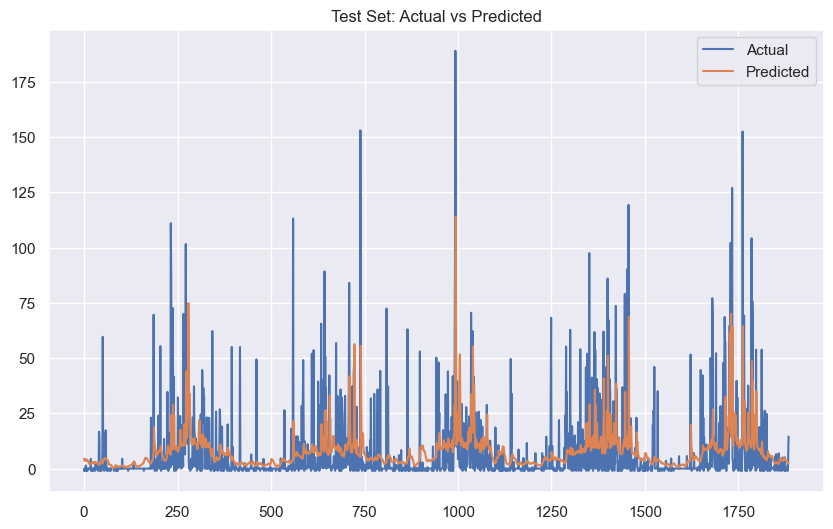

In [26]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
# Inverse scaling for predictions
train_predictions = scaler.inverse_transform(np.concatenate((train_predictions, X_train[:, -1, 1:]), axis=1))[:, 0]
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, X_test[:, -1, 1:]), axis=1))[:, 0]

# Inverse scaling for actual values
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.show()


In [27]:
data['RAINFALL']

Date
1998-01-01     0.0
1998-01-02     0.0
1998-01-03     0.0
1998-01-04     0.0
1998-01-05     0.0
              ... 
2023-12-27     0.2
2023-12-28     0.0
2023-12-29    -1.0
2023-12-30     7.2
2023-12-31    14.5
Name: RAINFALL, Length: 9496, dtype: float64

In [28]:
model.save("Model_rainfall.h5")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


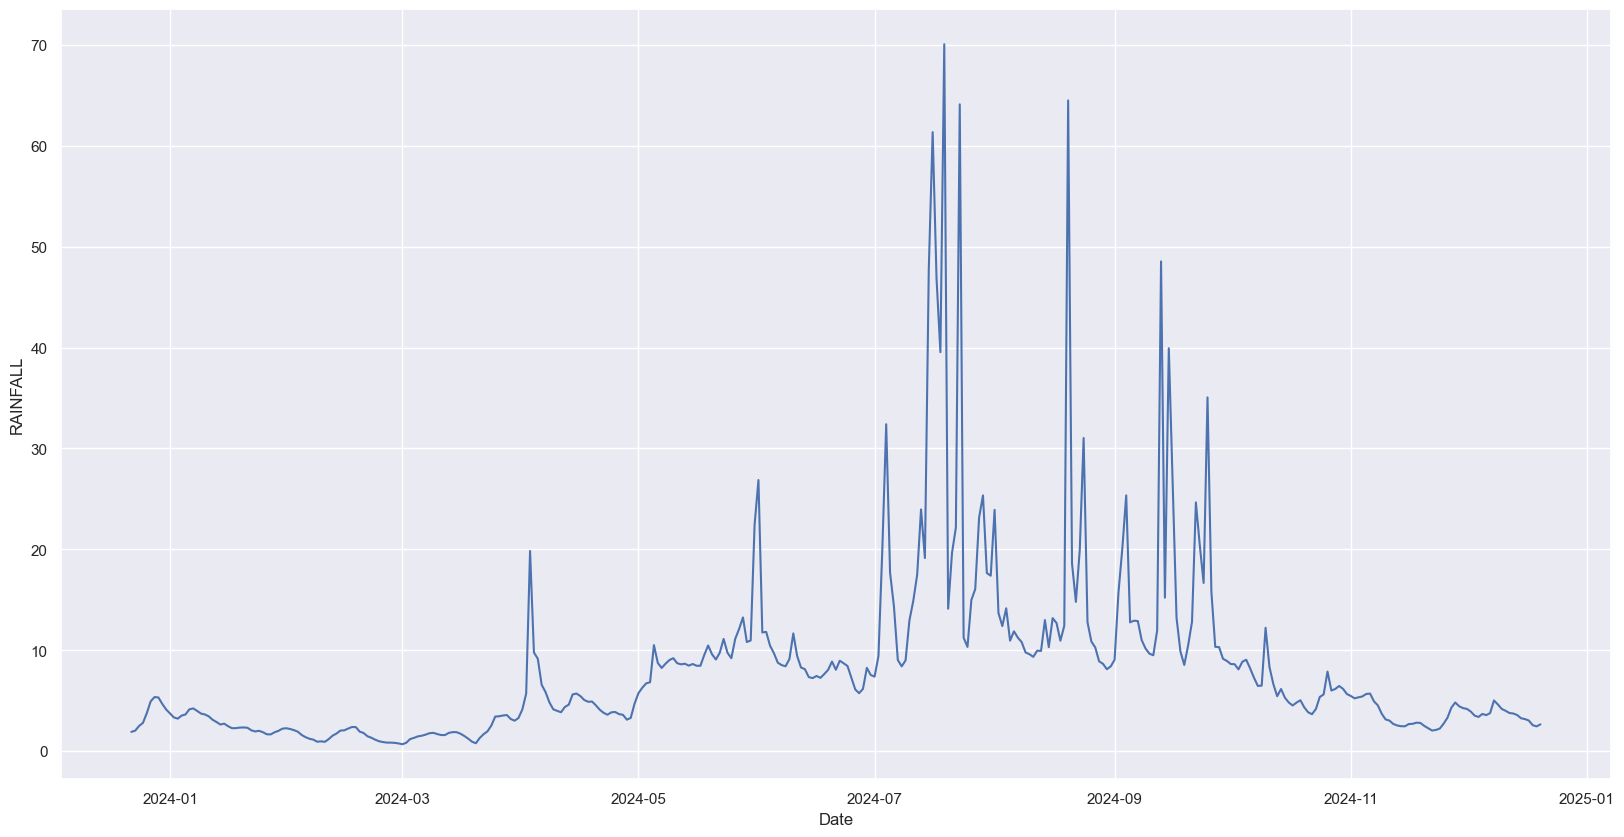

In [29]:
train_dates = list(data.index)
n_past = 10
n_days_for_prediction= 365
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq='d').tolist()
prediction = model.predict(X_test[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
prediction_copies = np.repeat(prediction, data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'RAINFALL':y_pred_future})
plt = sns.lineplot(data=df_forecast, x='Date', y='RAINFALL')
df_forecast.set_index('Date', inplace=True)


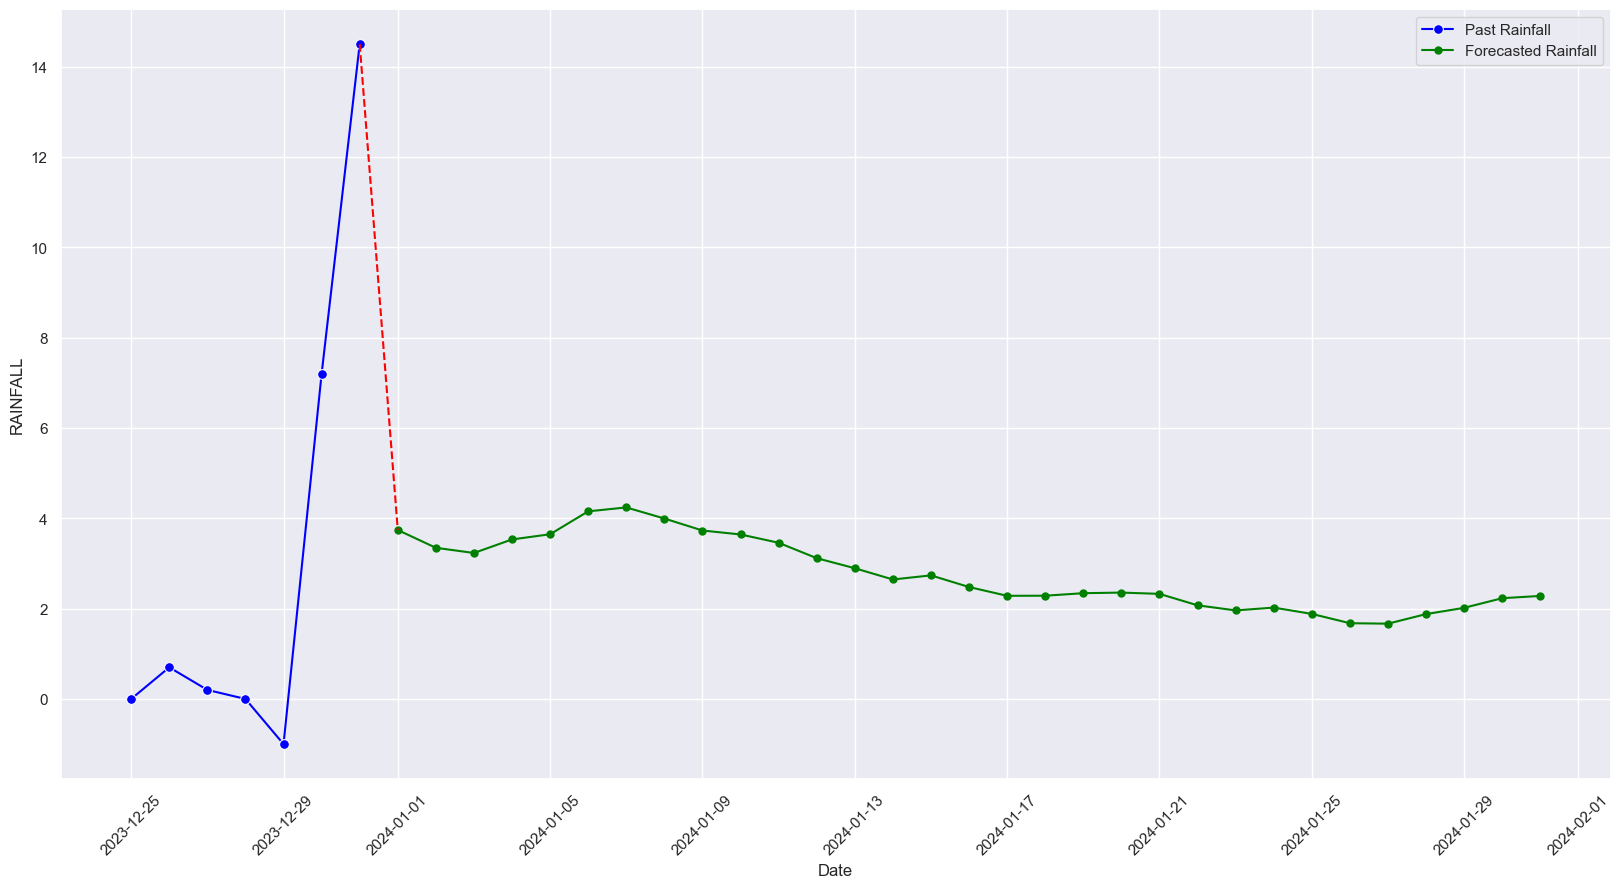

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# For the past data
original = data[['RAINFALL']]
original = original.loc[(original.index >= original.index[-7]) & (original.index <= original.index[-1])]

# For the forecasted data plot
last_known_date = original.index[-1]
start_date = last_known_date + pd.Timedelta(days=1)
forecast_end_date = start_date + pd.Timedelta(days=30)
forecast_dates = pd.date_range(start=start_date, end=forecast_end_date)
forecast_values = df_forecast.loc[forecast_dates, 'RAINFALL']

# Connect the past data to the forecasted data
last_known_value = original['RAINFALL'].iloc[-1]

# Plotting
sns.set(rc={'figure.figsize':(20, 10)})
sns.lineplot(data=original, x=original.index, y='RAINFALL', color='blue', marker='o', markersize=7, label='Past Rainfall')
plt.plot(forecast_dates, forecast_values, label='Forecasted Rainfall', color='green', marker='o', markersize=5)

# Connect past data to forecasted data
plt.plot([last_known_date, forecast_dates[0]], [last_known_value, forecast_values.iloc[0]], color='red', linestyle='--')

plt.xticks(rotation=45)
plt.legend()
plt.show()


In [31]:
# Calculate MAPE
mape = np.mean(np.abs((data - df_forecast) / data)) * 100
print(mape)

inf


In [32]:
y_true = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 6))), axis=1))
y_pred = scaler.inverse_transform(np.concatenate((model.predict(X_test).reshape(-1, 1), np.zeros((len(y_test), 6))), axis=1))

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print("Mean Absolute Error (MAE):", mae)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Mean Absolute Error (MAE): 1.2591590541422844


In [33]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
mse

Root Mean Squared Error (RMSE): 5.94919437168827


35.392913672127385

In [34]:
from sklearn.metrics import r2_score

# Calculate R-squared
r_squared = r2_score(y_true, y_pred)
print("R-squared:", r_squared)


R-squared: 0.8774706228113003
